# Grid Search with the Lending Club Loan Default Data

In this tutorial, we will go through a step-by-step workflow to determine loan deliquency. We will make predictions based only on the information available at the time the loan was issued.  The data for this exercise come from the public Lending Club data set, a description can be found [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook).

# Step 1. Start H2O-3 cluster

_**Note**: The `os.system` command below is used solely for the H2O Aquarium training platform._

In [1]:
import os
os.system('/home/h2o/bin/startup')
!sleep 10

Start by importing `h2o` and creating a connection to the server. The parameters used in `h2o.init` will depend on your specific environment.

In [2]:
import h2o
h2o.init(url='http://localhost:54321/h2o')

Checking whether there is an H2O instance running at http://localhost:54321/h2o . connected.


H2O cluster uptime:,09 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,2 months and 1 day
H2O cluster name:,h2o
H2O cluster total nodes:,1
H2O cluster free memory:,2.167 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Note: The method you use for starting and stopping an H2O-3 cluster will depend on how H2O is installed and configured on your system. Regardless of how H2O is installed, if you start a cluster, you will need to ensure that it is shut down when you are done.

# Step 2. Import data

The data set we use below is a local copy of https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/lending/lending_club/LoanStats3a.csv.

### View and Inspect the Data

The loans data set is loaded directly into H2O using the following command:

In [3]:
loans = h2o.import_file("/home/h2o/data/lending_club/LoanStats3a.csv",
                        col_types = {"int_rate":"string", 
                                     "revol_util":"string", 
                                     "emp_length":"string", 
                                     "verification_status":"string"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
loans.dim

[42536, 52]

# Step 3.  Clean data


## Part 1. Defining the problem and creating the response variable

The total number of loans in our data set is

In [5]:
num_unfiltered_loans = loans.dim[0]

Because we are interested in loan default, we need to look at the `loan_status` column.

In [6]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


Like many real data sources, `loan_status` is messy and contains multiple, somewhat overlapping, categories. Before modeling, we will need to clean this up by (a) removing loans that are still ongoing, and (b) simplifying the response column.

### (a) Filter Loans

In order to build a valid model, we have to remove loans that are still in process. They have `loan_status` like "Current" and "In Grace Period":

In [7]:
ongoing_status = ["Current",
                  "In Grace Period",
                  "Late (16-30 days)",
                  "Late (31-120 days)",
                  "Does not meet the credit policy.  Status:Current",
                  "Does not meet the credit policy.  Status:In Grace Period"
                 ]
loans = loans[~loans["loan_status"].isin(ongoing_status)]

After filtering out ongoing loans, we now have

In [8]:
num_filtered_loans = loans.dim[0]

loans whose final state is known, which means we filtered out

In [9]:
num_loans_filtered_out = num_unfiltered_loans - num_filtered_loans
num_loans_filtered_out

3556

loans. These loans are now summarized by `loan_status` as

In [10]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1933
Fully Paid,30843


### (b) Create Response Column

Let's name our response column `bad_loan`, which will equal one if the loan was not completely paid off.

In [11]:
fully_paid = ["Fully Paid",
              "Does not meet the credit policy.  Status:Fully Paid"
             ]
loans["bad_loan"] = ~(loans["loan_status"].isin(fully_paid))

Next make the `bad_loan` column a factor so that we can build a classification model,

In [12]:
loans["bad_loan"] = loans["bad_loan"].asfactor()

The percentage of bad loans is given by

In [13]:
bad_loan_dist = loans["bad_loan"].table()
bad_loan_dist["Percentage"] = (100 * bad_loan_dist["Count"] / loans.nrow).round()
bad_loan_dist

bad_loan,Count,Percentage
0,32776,84
1,6204,16


## Part 2. Convert strings to numeric

Consider the columns `int_rate`, `revol_util`, and `emp_length`:

In [14]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65%,83.7%,10+ years
15.27%,9.4%,< 1 year
15.96%,98.5%,10+ years
13.49%,21%,10+ years
7.90%,28.3%,3 years
18.64%,87.5%,9 years
21.28%,32.6%,4 years
12.69%,36.5%,< 1 year
14.65%,20.6%,5 years
12.69%,67.1%,10+ years


Both `int_rate` and `revol_util` are inherently numeric but entered as percentages. Since they include a "%" sign, they are read in as strings. The solution for both of these columns is simple: strip the "%" sign and convert the strings to numeric.

The `emp_length` column is only slightly more complex. Besides removing the "year" or "years" term, we have to deal with `< 1` and `10+`, which aren't directly numeric. If we define `< 1` as 0 and `10+` as 10, then `emp_length` can also be cast as numeric.

We demonstrate the steps for converting these string variables into numeric values below.

### Convert `int_rate`

In [15]:
loans["int_rate"] = loans["int_rate"].gsub(pattern = "%", replacement = "") # strip %
loans["int_rate"] = loans["int_rate"].trim() # trim whitespace
loans["int_rate"] = loans["int_rate"].asnumeric() # change to numeric 

### Convert `revol_util`

In [16]:
loans["revol_util"] = loans["revol_util"].gsub(pattern="%", replacement="") # strip %
loans["revol_util"] = loans["revol_util"].trim() # trim whitespace
loans["revol_util"] = loans["revol_util"].asnumeric() # change to numeric 

### Convert `emp_length`

In [17]:
# Use gsub to remove " year" and " years"; also translate n/a to "" 
loans["emp_length"] = loans["emp_length"].gsub(pattern="([ ]*+[a-zA-Z].*)|(n/a)", replacement="") 
loans["emp_length"] = loans["emp_length"].trim() # trim whitespace

loans["emp_length"] = loans["emp_length"].gsub(pattern="< 1", replacement="0") # convert "< 1" to 0
loans["emp_length"] = loans["emp_length"].gsub(pattern="10\\+", replacement="10") # convert "10+" to 10
loans["emp_length"] = loans["emp_length"].asnumeric() # trim whitespace

These steps result in

In [18]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65,83.7,10
15.27,9.4,0
15.96,98.5,10
13.49,21,10
7.9,28.3,3
18.64,87.5,9
21.28,32.6,4
12.69,36.5,0
14.65,20.6,5
12.69,67.1,10


## Part 3. Clean up messy categorical columns

Much as we did with the `loan_status` column, the `verification_status` column needs cleaning

In [19]:
loans["verification_status"].head()

verification_status
VERIFIED - income
VERIFIED - income source
not verified
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income
not verified
VERIFIED - income source


Because there are multiple values that mean verified ("VERIFIED - income" and "VERIFIED - income source"), we replace them simply with "verified",

In [20]:
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income source", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].asfactor()

resulting in

In [21]:
loans["verification_status"].table()

verification_status,Count
not verified,17947
verified,21032


# Step 4.  Feature engineering

Now that we have cleaned our data, we can extract information from our current columns to create new features. This process is referred to as _feature engineering_. The general idea is to express information found in our data in a manner that is most understandable to the algorithms we employ, with the goal of improving the performance of our supervised learning models.

Feature engineering can be considered the "secret sauce" in building a superior predictive model: it is often (although not always) more important than the choice of machine learning algorithm. A very good summary of feature engineering recipes can be found in the online [Driverless AI Documentation](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/transformations.html). 

We will do some basic feature engineering using the date fields in our data. The new columns we will create are: 
* `credit_length`: the number of years someone has had a credit history
* `issue_d_year` and `issue_d_month`: the year and month from the loan issue date

### Credit Length

We create the `credit_length` feature by subtracting the year of a customer's earliest credit line from the year they were issued the loan.

In [22]:
loans["credit_length"] = loans["issue_d"].year() - loans["earliest_cr_line"].year()
loans["credit_length"].head()

credit_length
26
12
10
15
7
4
7
7
13
22


### Issue Date Expansion

We next extract the year and month from the issue date.  We may find that the month or the year when the loan was issued will impact the probability of a bad loan. Additionally, since months are cyclical we will treat `issue_d_month` as a factor.

In [23]:
loans["issue_d_year"] = loans["issue_d"].year()
loans["issue_d_month"] = loans["issue_d"].month().asfactor()

loans[["issue_d_year", "issue_d_month"]].head()

issue_d_year,issue_d_month
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12


# Step 5. Model training

Now that we have cleaned our data and added new columns, we train a model to predict bad loans. First split our loans data into train and test.

In [24]:
train, test = loans.split_frame(seed=25, ratios=[0.75])

Next create a list of predictors as a subset of the columns of the `loans` H2O Frame

In [25]:
cols_to_remove = ["initial_list_status",
                  "out_prncp",
                  "out_prncp_inv",
                  "total_pymnt",
                  "total_pymnt_inv",
                  "total_rec_prncp", 
                  "total_rec_int",
                  "total_rec_late_fee",
                  "recoveries",
                  "collection_recovery_fee",
                  "last_pymnt_d", 
                  "last_pymnt_amnt",
                  "next_pymnt_d",
                  "last_credit_pull_d",
                  "collections_12_mths_ex_med" , 
                  "mths_since_last_major_derog",
                  "policy_code",
                  "loan_status",
                  "funded_amnt",
                  "funded_amnt_inv",
                  "mths_since_last_delinq",
                  "mths_since_last_record",
                  "id",
                  "member_id",
                  "desc",
                  "zip_code"]

predictors = list(set(loans.col_names) - set(cols_to_remove))

Now create an XGBoost model for predicting loan default. This model is being run with almost all of the model-tuning values at their defaults. Later we may want to optimize the hyperparameters using a grid search. 

In [26]:
from h2o.estimators import H2OXGBoostEstimator

param = {
      "ntrees" : 20
    , "nfolds" : 5
    , "seed": 25
}
xgboost_model = H2OXGBoostEstimator(**param)
xgboost_model.train(x = predictors,
                    y = "bad_loan",
                    training_frame=train,
                    validation_frame=test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Step 6.  Examine model accuracy

The plot below shows the performance of the model as more trees are built.  This graph can help us see at what point our model begins overfitting.  Our test data error rate stops improving at around 8-10 trees.

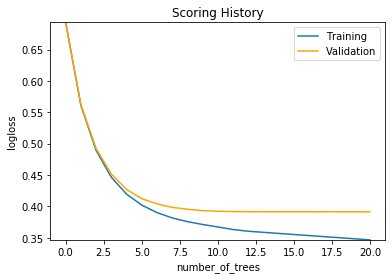

In [27]:
%matplotlib inline
xgboost_model.plot()

The ROC curve of the training and testing data are shown below.  The area under the ROC curve is much higher for the training data than the test data, indicating that the model is beginning to memorize the training data.

Training Data


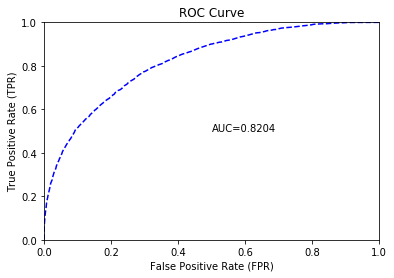

Testing Data


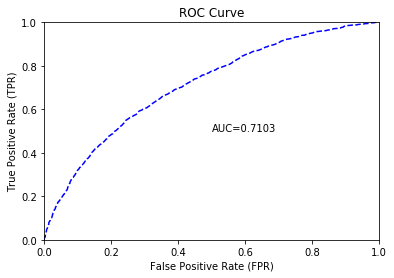

X-Val


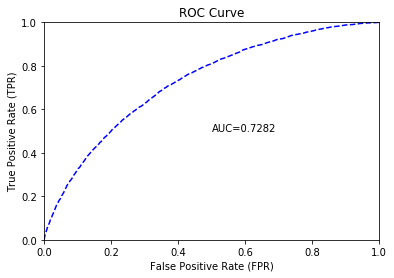

In [28]:
print("Training Data")
xgboost_model.model_performance(train = True).plot()
print("Testing Data")
xgboost_model.model_performance(valid = True).plot()
print("X-Val")
xgboost_model.model_performance(xval=True).plot()

# Step 7. Interpret model

The variable importance plot shows us which variables are most important to predicting `bad_loan`.  We can use partial dependency plots to learn more about how these variables affect the prediction.

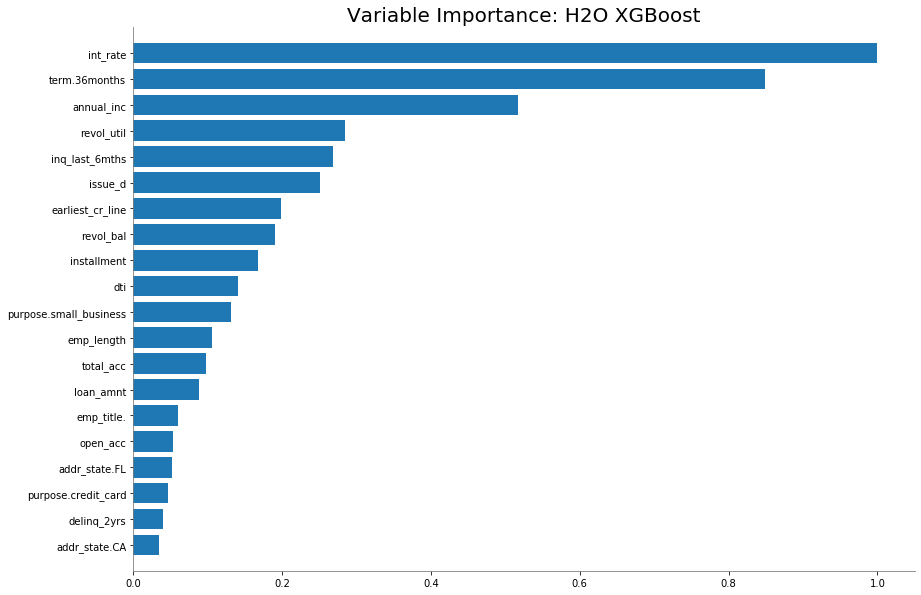

In [29]:
xgboost_model.varimp_plot(20)

As suspected, interest rate appears to be the most important feature in predicting loan default. The partial dependency plot of the `int_rate` predictor shows us that as the interest rate increases, the likelihood of the loan defaulting also increases.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


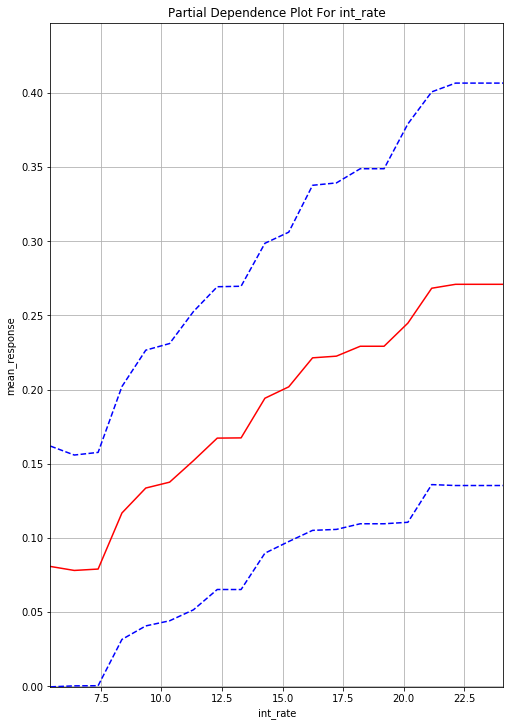

In [30]:
pdp = xgboost_model.partial_plot(cols=["int_rate"], data=train)

# Step 8. H2O Grid Search

Now that we have prepared the data, we can train some models.  Rather than training models manually one-by-one as we did above, we will make use of the H2O Grid Search functionality to train a bunch of models at once.

H2O offers two types of grid search: **Cartesian** and **RandomDiscrete**.  Cartesian is the traditional, exhaustive, grid search over all the combinations of model parameters in the grid.  Random Grid Search will sample sets of model parameters randomly for some specified period of time or maximum number of models.

We will use XGBoost as an example to demonstrate H2O's grid search functionality.

In [31]:
# Import H2O Grid Search:
from h2o.grid.grid_search import H2OGridSearch

## Cartesian Grid Search

We first need to define a grid of XGBoost model hyperparameters.  For this particular example, we will grid over the following model parameters:

- `learn_rate`
- `max_depth`
- `sample_rate`
- `col_sample_rate`

In [32]:
# GBM hyperparameters
xgb_params1 = {'learn_rate': [0.01, 0.1], 
               'max_depth': [3, 5, 9],
               'sample_rate': [0.8, 1.0],
               'col_sample_rate': [0.2, 0.5, 1.0]}

### Train and validate a grid of XGBoost Models

If you want to specify non-default model parameters that are not part of your grid, you pass them along to the grid via the `H2OGridSearch.train()` method.  See `ntrees=100` in the example below.

In [33]:
xgb_grid1 = H2OGridSearch(model=H2OXGBoostEstimator,
                          grid_id='xgb_grid1',
                          hyper_params=xgb_params1)
xgb_grid1.train(x = predictors,
                y = "bad_loan",
                training_frame = train,
                validation_frame = test,
                ntrees=100,
                seed=1)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


### Compare model performance

To compare the model performance among all the models in a grid, sorted by a particular metric (e.g. AUC), you can use the `get_grid` method. 

In [34]:
xgb_gridperf1 = xgb_grid1.get_grid(sort_by='auc', decreasing=True)
print(xgb_gridperf1) 

     col_sample_rate learn_rate max_depth sample_rate           model_ids  \
0                1.0        0.1         5         0.8  xgb_grid1_model_12   
1                0.5        0.1         5         0.8  xgb_grid1_model_11   
2                0.5        0.1         5         1.0  xgb_grid1_model_29   
3                0.2        0.1         5         1.0  xgb_grid1_model_28   
4                0.2        0.1         3         0.8   xgb_grid1_model_4   
5                0.2        0.1         9         0.8  xgb_grid1_model_16   
6                0.2        0.1         5         0.8  xgb_grid1_model_10   
7                1.0        0.1         5         1.0  xgb_grid1_model_30   
8                0.5        0.1         3         0.8   xgb_grid1_model_5   
9                1.0        0.1         3         0.8   xgb_grid1_model_6   
10               1.0        0.1         3         1.0  xgb_grid1_model_24   
11               0.5        0.1         3         1.0  xgb_grid1_model_23   

## Random Grid Search
This example is set to run fairly quickly -- increase `max_runtime_secs` or `max_models` to cover more of the hyperparameter space.  Also, you can expand the hyperparameter space of each of the algorithms by modifying the hyper parameter list below.

In addition to the hyperparameter dictionary, we will specify the `search_criteria` as 'RandomDiscrete', with a max numeber of models equal to 36. 

In [35]:
# GBM hyperparameters
xgb_params2 = {'learn_rate': [i * 0.01 for i in range(1, 11)],
               'max_depth': list(range(2, 11)),
               'sample_rate': [i * 0.1 for i in range(5, 11)],
               'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria2 = {'strategy': 'RandomDiscrete', 'max_models': 36}

### Train and validate a random grid of GBMs

In [ ]:
xgb_grid2 = H2OGridSearch(model = H2OXGBoostEstimator,
                          grid_id = 'xgb_grid2',
                          hyper_params = xgb_params2,
                          search_criteria = search_criteria2)

xgb_grid2.train(x = predictors,
                y = "bad_loan",
                training_frame = train,
                validation_frame = test,
                ntrees=100,
                seed=1)

xgboost Grid Build progress: |███████████████████

### Compare model performance

In [ ]:
xgb_gridperf2 = xgb_grid2.get_grid(sort_by='auc', decreasing=True)
print(xgb_gridperf2)

### Add models to existing grid
It looks like `learn_rate=0.1` does well here, which was the biggest `learn_rate` in our previous search, so maybe we want to add some models to our grid search with a higher `learn_rate`.  We will create a new `hyper_params` and `search_criteria` objects.

We can add models to the same grid, by re-using the same `model_id`. Let's add as many new models as we can train in 60 seconds by setting `max_runtime_secs=60` in `search_criteria`.

In [ ]:
# GBM hyperparameters
xgb_params = {'learn_rate': [i * 0.01 for i in range(1, 31)],  # updated
              'max_depth': list(range(2, 11)),
              'sample_rate': [0.9, 0.95, 1.0],  # updated
              'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_runtime_secs': 60}  # updated

xgb_grid = H2OGridSearch(model = H2OXGBoostEstimator,
                         grid_id = 'xgb_grid2',
                         hyper_params = xgb_params,
                         search_criteria = search_criteria)

xgb_grid.train(x = predictors,
               y = "bad_loan",
               training_frame = train,
               validation_frame = test,
               ntrees = 100,
               seed = 1)

In [ ]:
xgb_gridperf = xgb_grid.get_grid(sort_by='auc', decreasing=True)
print(xgb_gridperf)

Lastly, let's extract the top model, as determined by validation AUC, from the grid.

In [ ]:
# Grab the model_id for the top GBM model, chosen by validation AUC
best_xgb_model = xgb_gridperf.models[0]

In [ ]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance

xgb_perf = best_xgb_model.model_performance(test)
print(xgb_perf.auc())

This is slighly higher than the AUC on the validation set of the top model, however, model performance evaluated on a held-out test set is a more honest estimate of performance.  The validation set was used to select the best model, but should not be used to also evaluate the best model's performance.

# Step 9. AutoML

AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit or user specified model build limit. 

Stacked Ensembles will be automatically trained on collections of individual models to produce highly predictive ensemble models.

In [ ]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=5, 
                max_runtime_secs_per_model=60, 
                include_algos = ["GLM", "DRF", "XGBoost", "StackedEnsemble"],
                seed=25)
aml.train(x=predictors, y='bad_loan', training_frame=train)

_While the AutoML job is running, you can open H2O Flow and monitor the model building process._

Once complete, the leaderboard contains the performance metrics of the models generated by AutoML:

In [ ]:
aml.leaderboard

Since we provided only the training H2O Frame during training, the models are sorted by their cross-validated performance metrics (AUC by default for classification). We can evaluate the best model (`leader`) on the test data:

In [ ]:
aml.leader.model_performance(test_data=test).plot()
aml.leader.model_performance(test_data=test)

Another convenient use of H2O Flow is to explore the various models built by AutoML.

# Step 10. Stop H2O-3 cluster

In [ ]:
h2o.cluster().shutdown()

Once your work is completed, shutting down the H2O cluster frees up the resources reserved by H2O.

# Bonus: H2O-3 documentation

* http://docs.h2o.ai